# SWOP script 3
## Baseline Regression with ERP Visualizations

Analysis script associated with the manuscript: ***Native word order processing is not uniform: An ERP-study of verb-second word order***, by Susan Sayehli, Marianne Gullberg, Aaron Newman, and Annika Andersson. (2022). *Frontiers in Psychology - Language Sciences*. DOI:[10.3389/fpsyg.2022.668276](https://www.frontiersin.org/articles/10.3389/fpsyg.2022.668276).

This notebook reads in the *-epo.fif evoked files from individual subjects that were produced by the batch individual subject preprocessing in the script *SWOP 1 - Preprocessing*. 

### Baseline Regression 
Implements the baseline regression approach described in:

Alday, P. M. (2019). How much baseline correction do we need in ERP research? Extended GLM model can replace baseline correction while lifting its limits. *Psychophysiology* 56, e13451. doi: [10.1111/psyp.13451](https://doi.org/10.1111/psyp.13451) ([preprint version here](https://arxiv.org/abs/1707.08152))

Alday's code is adapted here, including extending it to apply regression separately to each channel. (Alday's original code applies the electrode Cz's baseline to every channel.)

This script serves to generate the visualizations of the data reported in the manuscript, including ERP waveforms and topographical maps. Note however that the data submitted to mixed-effects modelling are not the baseline-regressed data from this script. The data for mixed-effects modelling are computed and exported by script 4.

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca), [including code adapted from Alday](https://osf.io/pnaku/)

Released under the [The 3-Clause BSD License](https://opensource.org/licenses/BSD-3-Clause)

---

## Load in the necessary libraries/packages we'll need

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import pandas as pd
import seaborn as sns

import mne       
mne.set_log_level(verbose='error')

# For big arrays of waveplots
figsize = (18, 14)

# Change this to 300 for generating hi rez (poster/paper) images. Use 72 for on-screen viewing. Number affects size of image on screen
dpi = 72
matplotlib.rcParams['figure.dpi'] = dpi

## List of subjects

In [2]:
subjects = ['s_04nm',  's_07ba',  's_09lo',  's_12wg',  's_13ff',  's_14mc',
            's_15rj',  's_17oh',  's_18ak',  's_19am',  's_21ma',  's_23nj',
            's_24zk',  's_25ks',  's_26nm',  's_27lm',  's_28js',  's_29ld',
            's_30la',  's_31bf']

## Time windows of interest

In [3]:
# Define the traditional baseline window
baseline = (-.100, 0.)
tmin, tmax = -.100, 1.
# Define start & end of time window to compute mean amplitude over
time_wins = [(.100, .300), (.300, .500), (.500, .700), (.700, .900), (.900, 1.000)]

components = {'baseline':{'tw':(-.100, 0.), 'tw_width':.100},
              '100-300':{'tw':(.100, .300), 'tw_width':.200},
              '300-500':{'tw':(.300, .500), 'tw_width':.200},
              '500-700':{'tw':(.500, .700), 'tw_width':.200},
              '700-900':{'tw':(.700, .900), 'tw_width':.200},
              '900-1000':{'tw':(.900, 1.), 'tw_width':.100},
              }

## Conditions and Contrasts of Interest

In [4]:
target_words = ['kanske', 'hemma', 'idag']

conditions = ['V2/kanske', 'V3/kanske', 
              'V2/hemma',  'V3/hemma',
              'V2/idag',   'V3/idag'
             ]

contrasts = {'kanske':['V3/kanske', 'V2/kanske'],
             'hemma':['V3/hemma',   'V2/hemma'],
             'idag':['V3/idag',     'V2/idag'],             
             }

### Colors to use in plotting waveforms

In [5]:
colors = {'V2/kanske':'blue', 
          'V3/kanske':'dodgerblue', 
          'V2/hemma':'green', 
          'V3/hemma':'limegreen', 
          'V2/idag':'orangered',
          'V3/idag':'orange'
         }

linestyles = {'V2/kanske':'-', 
              'V3/kanske': '--', 
              'V2/hemma':'-', 
              'V3/hemma':'--', 
              'V2/idag':'-',
              'V3/idag':'--'
             }

In [6]:
contr_colors = {'kanske':'blue', 
                'hemma':'green', 
                'idag':'orangered',
               }

contr_linestyles = {'kanske':'-', 
                    'hemma':':', 
                    'idag':'-.',
                   }

## Paths to read and write data

In [7]:
data_path = '../data/'
out_path = '../group_data/'
figure_path = '../results/figures/' + str(dpi) + ' dpi/'
svg_path = '../results/figures/svg/'

---

# Read in the data

Re-reference to averaged mastoids on import

In [8]:
epochs = {}
epochs_remapped = {}
for subject in subjects:
    epochs[subject] = mne.read_epochs(str(data_path + subject + '-epo.fif'),
                                         proj=False, 
                                         verbose=None, 
                                         preload=True).set_eeg_reference(ref_channels=['M1', 'M2'])

## Create Evokeds

In [9]:
evokeds = {}
for cond in conditions:   
    evokeds[cond] = [epochs[subject][cond].copy().crop(tmin, tmax).average() for subject in subjects]

## Define ROIs
clusters of electrodes to average over for waveform plots

In [10]:
rois = {'L_Ant':['F7', 'FT7', 'F3', 'FC3'],
        'M_Ant':['Fz'],
        'R_Ant':['F8', 'FT8', 'F4', 'FC4'],
        'L_Cent':['T7', 'TP7', 'C3', 'CP3'], 
        'M_Cent':['Cz'], 
        'R_Cent':['T8', 'TP8', 'C4', 'CP4'],
        'L_Post':['P7', 'P3', 'PO7', 'O1'],
        'M_Post':['Pz'],
        'R_Post':['P8', 'P4', 'PO8', 'O2'],
        'Other':['Fp1', 'Fp2', 'M1', 'M2']
       }

roi_order = ['L_Ant', 'M_Ant', 'R_Ant',
             'L_Cent', 'M_Cent', 'R_Cent',
             'L_Post', 'M_Post', 'R_Post'
            ]


ch_roi_map = {}
for roi, chans in rois.items():
    for chan in chans:
        ch_roi_map[chan] = roi

# We don't need Other anymore, and it screws things up below.    
rois.pop('Other');   

---
## Regression baseline

Code adapted from Alday (2019)

In [11]:
%%time
eeg_chans = epochs[subject].copy().pick_types(eeg=True, eog=False).info['ch_names']

evokeds_regressed = {x: {y: [] 
                         for y in eeg_chans} 
                     for x in conditions}

baseline_ts = {x: {y: [] 
                   for y in eeg_chans} 
               for x in conditions}

for subject in subjects:
    dat = epochs[subject].copy().pick_types(eeg=True, eog=False).crop(tmin, tmax).get_data()
    # convert ms to time points
    bs_tp = int((baseline[1] - baseline[0]) * epochs[subject].info['sfreq'])
    # Compute average over baseline period for each trial and channel
    dat_bs = dat[:, :, :bs_tp].mean(axis=-1).squeeze()

    # MNE's linear_regression does not allow different design matrices for different channels
    # So we need to fit the model separately for each channel
    for ch_num, ch_name in enumerate(eeg_chans): #range(epochs[subject].info['nchan']):
        
        # Make design matrix
        design_matrix = []
        names = []

        dat_bs_ch = dat_bs[:, ch_num]
        design_matrix.append(dat_bs_ch)  
        names.append('baseline')
        
        first_cond = True
        for cond in conditions:
            design_matrix.append(np.isin(epochs[subject].selection, epochs[subject][cond].selection).tolist())
            names.append(cond)
            # hack because we want conditionXbaseline interactions for all but first condition
            if not first_cond:
                design_matrix.append(design_matrix[-1] * dat_bs_ch)
                names.append('baseline:' + cond)
            first_cond = False

        design_matrix = np.stack(design_matrix).T    

        # Linear regression
        regmodel = mne.stats.linear_regression(epochs[subject].copy().pick_types(eeg=True, eog=False).crop(tmin, tmax), 
                                               design_matrix,
                                               names=names)
        
        # Store results as evokeds structure
        first_cond = True
        for cond in conditions:
            evokeds_regressed[cond][ch_name].append(regmodel[cond].beta)
            if first_cond:
                bs = regmodel['baseline'].beta
                first_cond = False
            else:
                bs = mne.combine_evoked([regmodel['baseline'].beta,
                                         regmodel['baseline:' + cond].beta],
                                        [1, 1])

            baseline_ts[cond][ch_name].append(bs)

CPU times: user 5min 18s, sys: 3min 1s, total: 8min 19s
Wall time: 1min 22s


### View sample design matrix

In [12]:
pd.DataFrame(design_matrix[:10,:], columns=names)

baseline  V2/kanske  V3/kanske  baseline:V3/kanske  V2/hemma  \
0 -3.061946e-06        0.0        0.0       -0.000000e+00       1.0   
1  3.046148e-06        0.0        0.0        0.000000e+00       0.0   
2 -3.795382e-06        0.0        0.0       -0.000000e+00       0.0   
3  1.519073e-06        0.0        0.0        0.000000e+00       0.0   
4 -5.082723e-06        1.0        0.0       -0.000000e+00       0.0   
5 -1.076097e-06        0.0        1.0       -1.076097e-06       0.0   
6 -1.970992e-07        0.0        0.0       -0.000000e+00       0.0   
7 -7.865024e-07        0.0        1.0       -7.865024e-07       0.0   
8  1.427171e-06        1.0        0.0        0.000000e+00       0.0   
9  3.460769e-07        0.0        0.0        0.000000e+00       0.0   

   baseline:V2/hemma  V3/hemma  baseline:V3/hemma  V2/idag  baseline:V2/idag  \
0          -0.000003       0.0      -0.000000e+00      0.0         -0.000000   
1           0.000000       1.0       3.046148e-06      0.0          0.000000   
2          -0.000000       0.0      -0.000000e+00      1.0         -0.000004   
3           0.000000       0.0       0.000000e+00      1.0          0.000002   
4          -0.000000       0.0      -0.000000e+00      0.0         -0.000000   
5          -0.000000       0.0      -0.000000e+00      0.0         -0.000000   
6          -0.000000       1.0      -1.970992e-07      0.0         -0.000000   
7          -0.000000       0.0      -0.000000e+00      0.0         -0.000000   
8           0.000000       0.0       0.000000e+00      0.0          0.000000   
9           0.000000       0.0       0.000000e+00      0.0          0.000000   

   V3/idag  baseline:V3/idag  
0      0.0     -0.000000e+00  
1      0.0      0.000000e+00  
2      0.0     -0.000000e+00  
3      0.0      0.000000e+00  
4      0.0     -0.000000e+00  
5      0.0     -0.000000e+00  
6      0.0     -0.000000e+00  
7      0.0     -0.000000e+00  
8      0.0      0.000000e+00  
9      1.0      3.460769e-07

### Create evoked with by-channel regressed baseline

In [13]:
evokeds_reg_merged = evokeds.copy()

for cond in conditions:
    for s_idx, subject in enumerate(subjects):
        for c_idx, chan in enumerate(eeg_chans):
            evokeds_reg_merged[cond][s_idx].data[c_idx, :] = evokeds_regressed[cond][chan][s_idx].data[c_idx, :]

### Write out baseline-regressed evokeds

In [14]:
for cond, evoked in evokeds_reg_merged.items():
    mne.write_evokeds(out_path + 'SWOP_regrBsln_' + cond.replace('/', '_') + '-evo.fif', evoked)

## Grand Averages

In [15]:
gavg = {}
for cond in conditions:
    gavg[cond] = mne.grand_average(evokeds_reg_merged[cond])

## Compute Contrasts
Differences between pairs of conditions

In [16]:
evokeds_diff = {}

for contr, conds in contrasts.items():
    evokeds_diff[contr] = [mne.combine_evoked([ c1, c2],
                                              weights=[1, -1])
                          for (c1, c2) in zip(evokeds_reg_merged[conds[0]], 
                                              evokeds_reg_merged[conds[1]])
                         ]

---
# Visualization

## Butterfly plots with peak finding

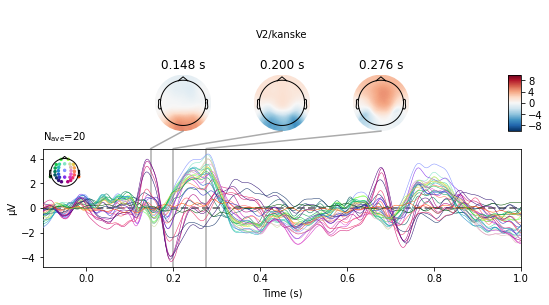

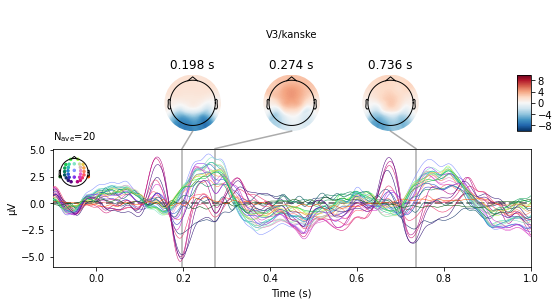

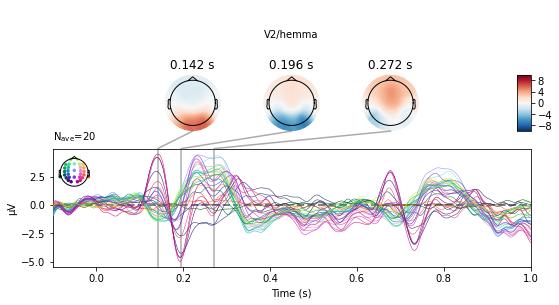

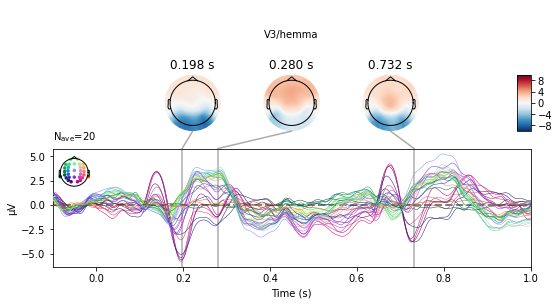

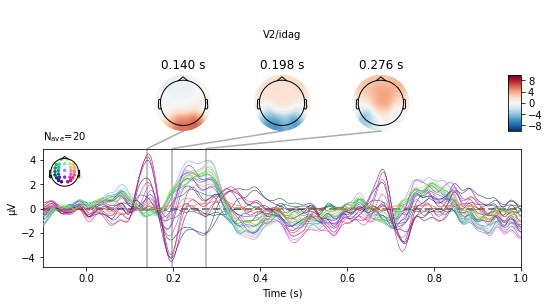

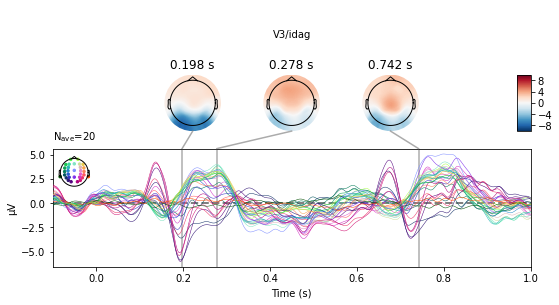

In [17]:
# auto peak-finding will only find at most 3 peaks
uv_range = 10

for cond in conditions:
    gavg[cond].plot_joint(title=(cond), 
                          ts_args={'hline':[0]},
                          topomap_args={'sensors':False, 'contours':False, 
                                       'vmin':-uv_range, 'vmax':uv_range})

## Topo map time series for each condition

These are not terribly informative, except to veryfiy that in general terms, the averages for all conditions look broadly similar and non-problematic.

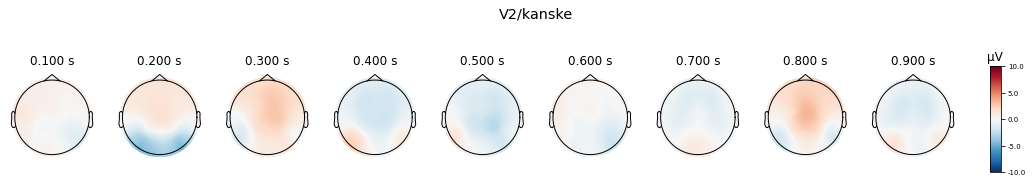

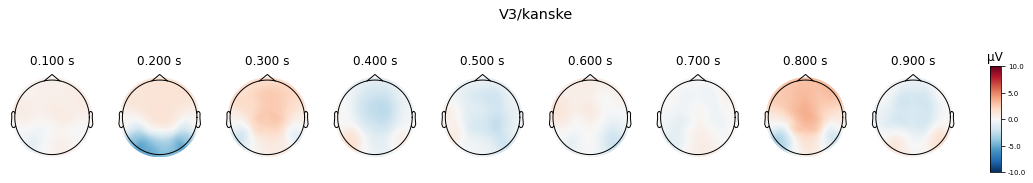

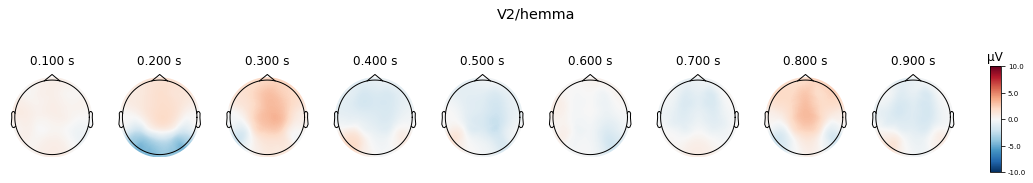

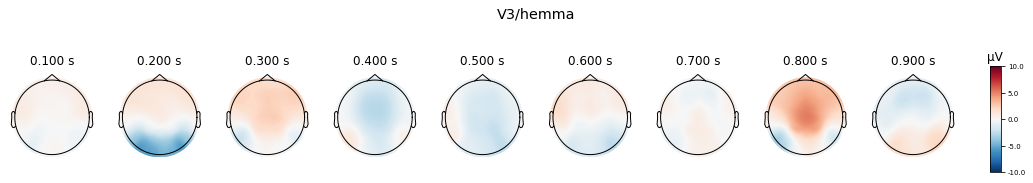

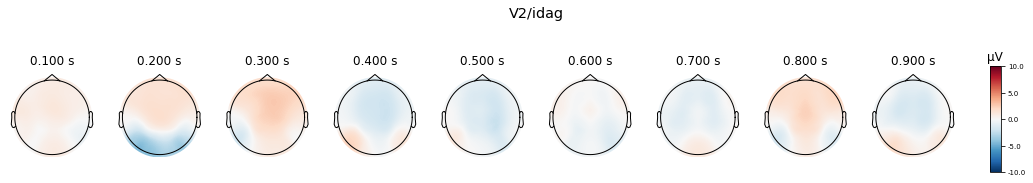

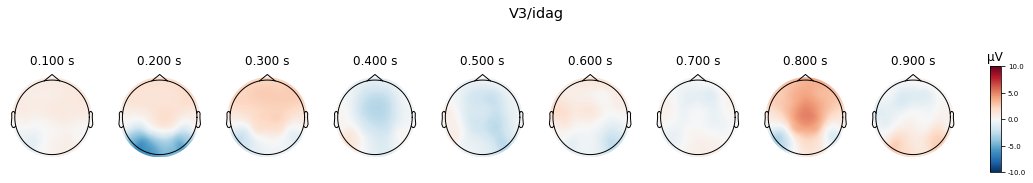

In [18]:
times = np.arange(.100, 1.000, .100)

uv_range = 10

for cond in conditions:
    gavg[cond].plot_topomap(times, average=0.050,
                           ch_type='eeg', 
                           show_names=False, sensors=False, contours=False, 
                           colorbar=True, 
                           vmin=-uv_range, vmax=uv_range,
                           title=(cond)
                          )

## Waveforms

### All conditions overlaid

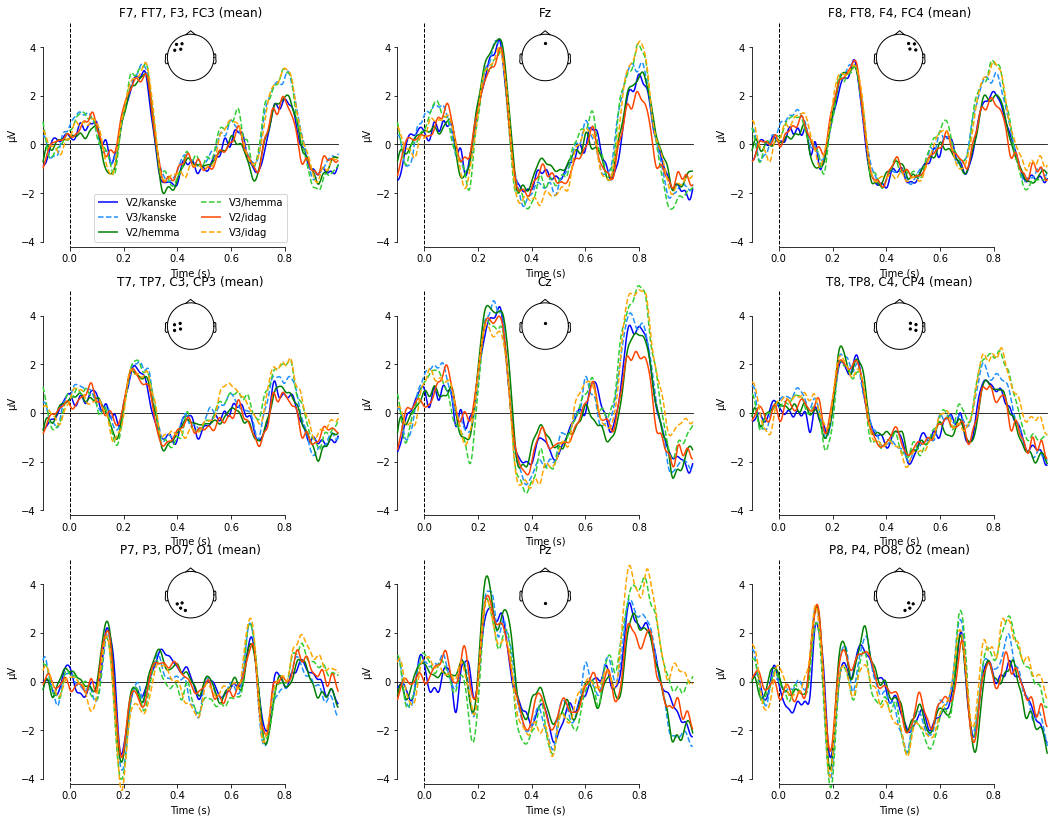

In [19]:
ylim = {'eeg':[-4.2, 5]}
head_pos = 'upper center'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == 0:
        legend='lower center'
        show=False
    elif ax == (len(rois.items())-1):
        legend=False
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions},
                                 picks=chans, combine='mean',
                                 colors=colors, linestyles=linestyles,
                                 ylim=ylim,
                                 show_sensors=head_pos, legend=legend, 
                                 ci=False,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_all_cond_' + str(dpi) + 'dpi.png');
fig.savefig(svg_path + 'waveforms_all_cond_.svg');
plt.close();
plt.show()

## Plot by condition

### kanske
#### V2 vs. V3

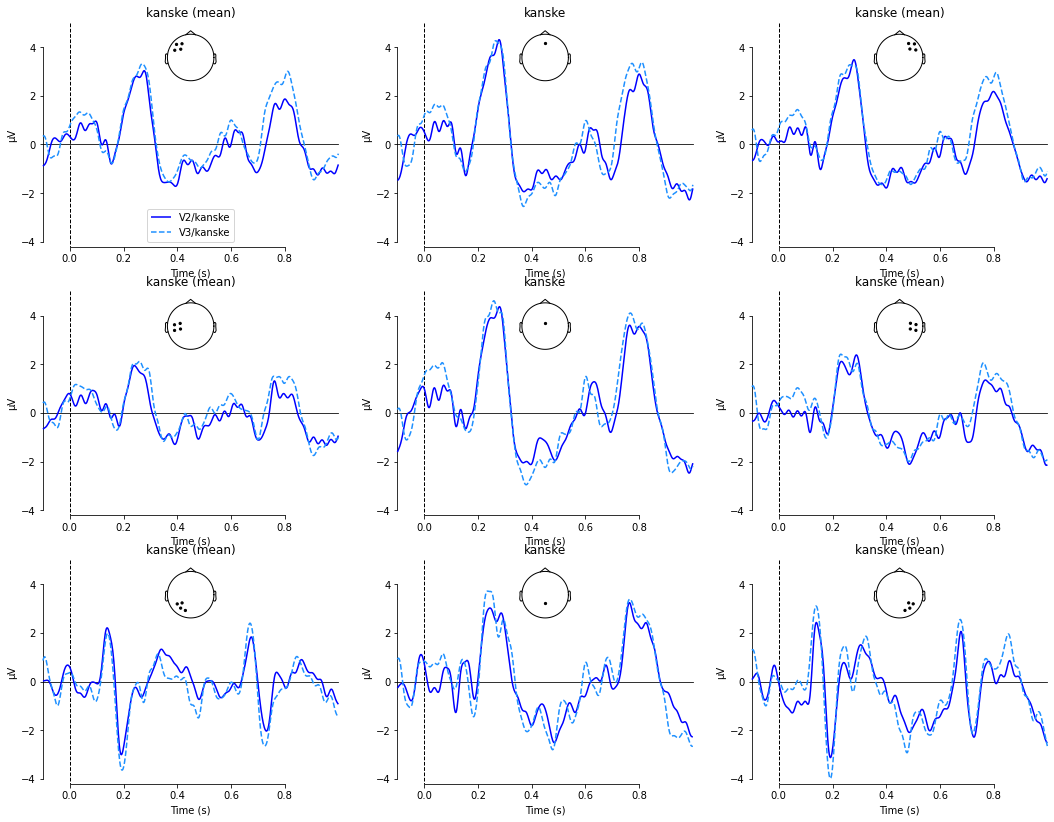

In [20]:
cond = 'kanske'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == 0:
        legend='lower center'
        show=False
    elif ax == (len(rois.items())-1):
        legend=False
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in  conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=False,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '.svg')
plt.close()
plt.show()

### hemma
#### V2 vs. V3

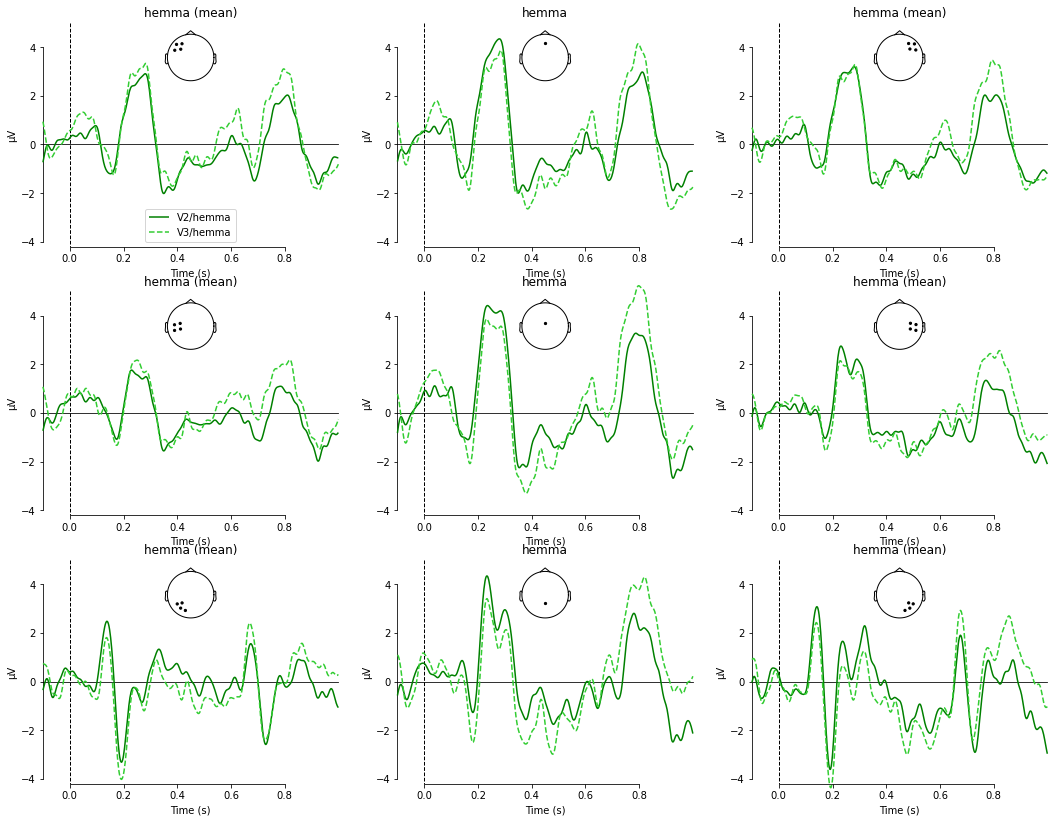

In [21]:
cond = 'hemma'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == 0:
        legend='lower center'
        show=False
    elif ax == (len(rois.items())-1):
        legend=False
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in  conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=False,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '.svg')

plt.close()
plt.show()

### Idag
#### V2 vs. V3

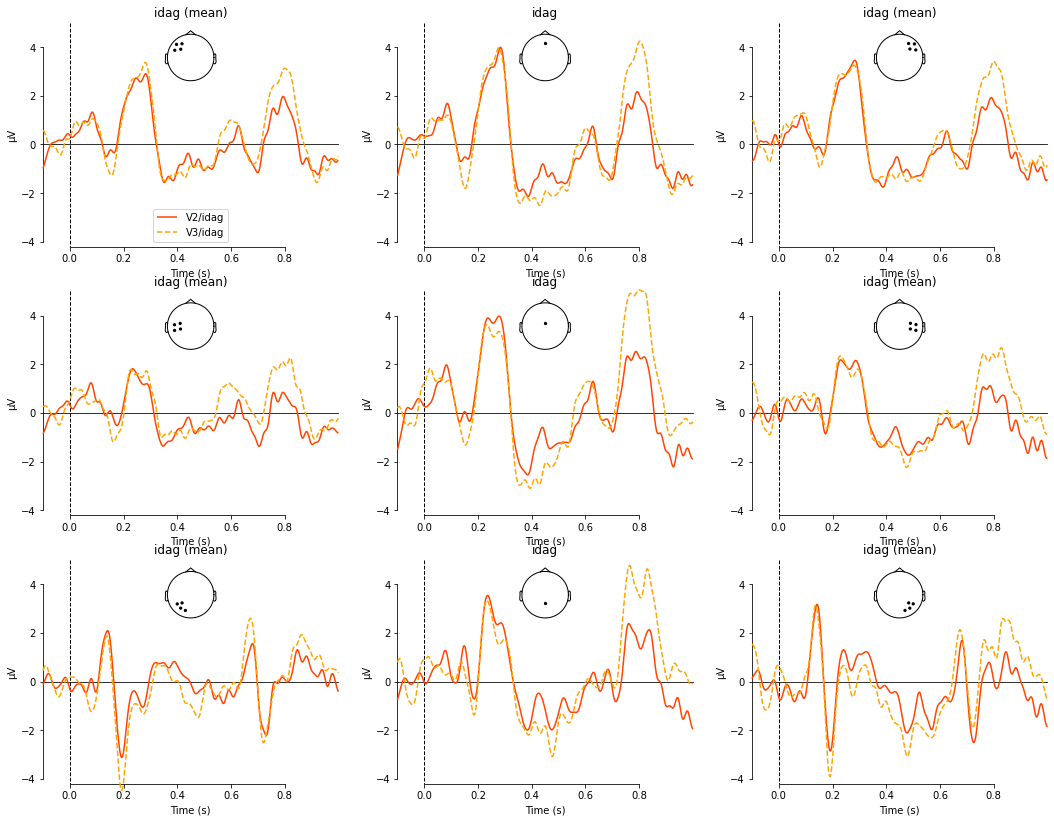

In [22]:
cond = 'idag'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == 0:
        legend='lower center'
        show=False
    elif ax == (len(rois.items())-1):
        legend=False
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in  conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=False,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '.svg')
plt.close()
plt.show()

## With CIs

### kanske
#### V2 vs. V3

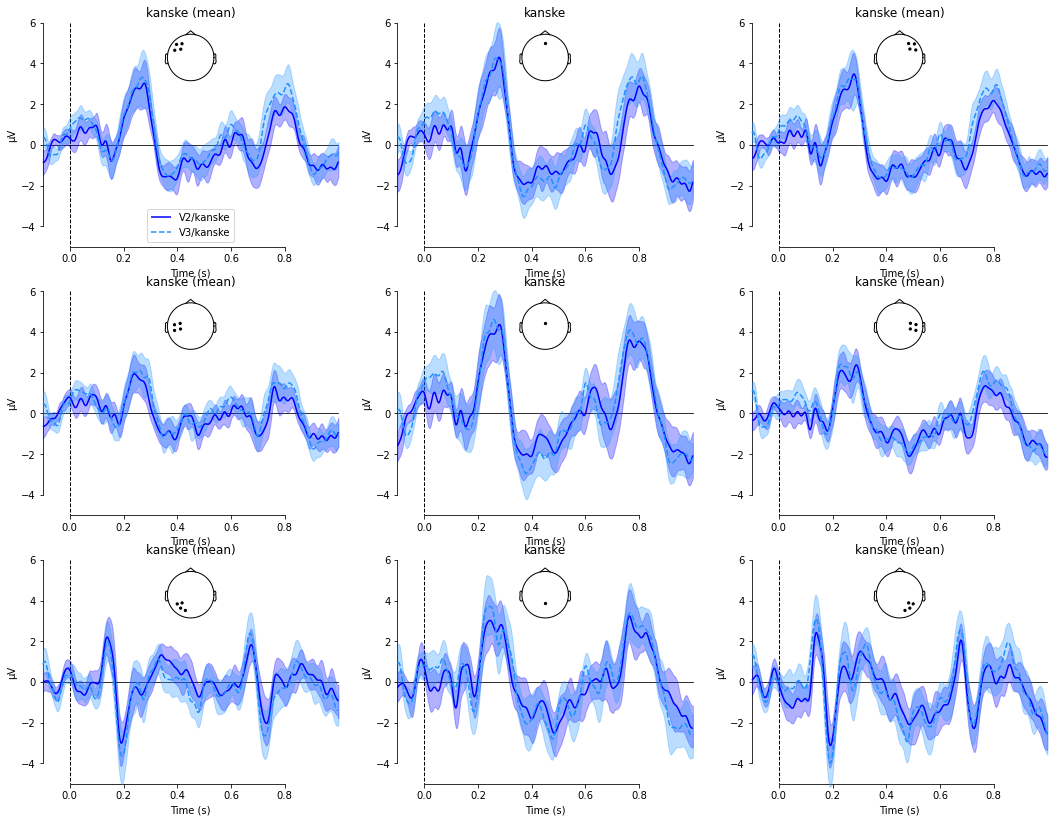

In [23]:
cond = 'kanske'
ylim = {'eeg':[-5, 6]}

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == 0:
        legend='lower center'
        show=False
    elif ax == (len(rois.items())-1):
        legend=False
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_CIs_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '_CIs.svg')
plt.close()
plt.show()

### hemma
#### V2 vs. V3

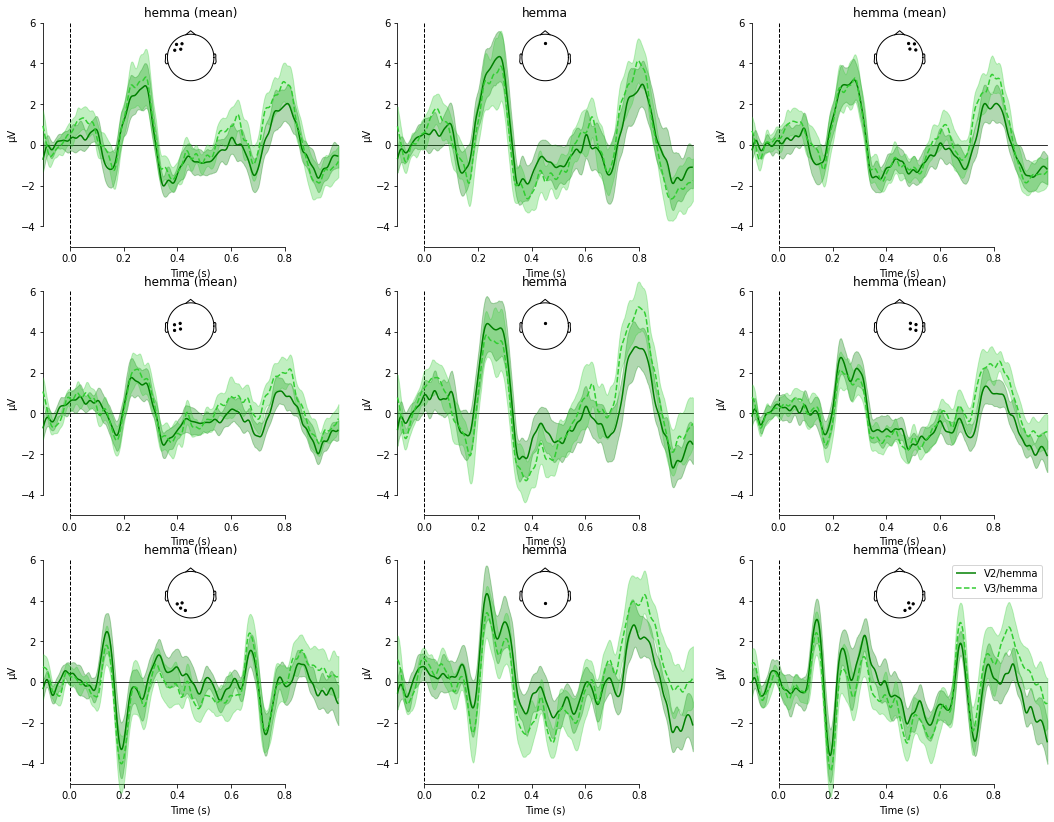

In [24]:
cond = 'hemma'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='upper right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in  conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_CIs_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '_CIs.svg')
plt.close()
plt.show()

### Idag
#### V2 vs. V3

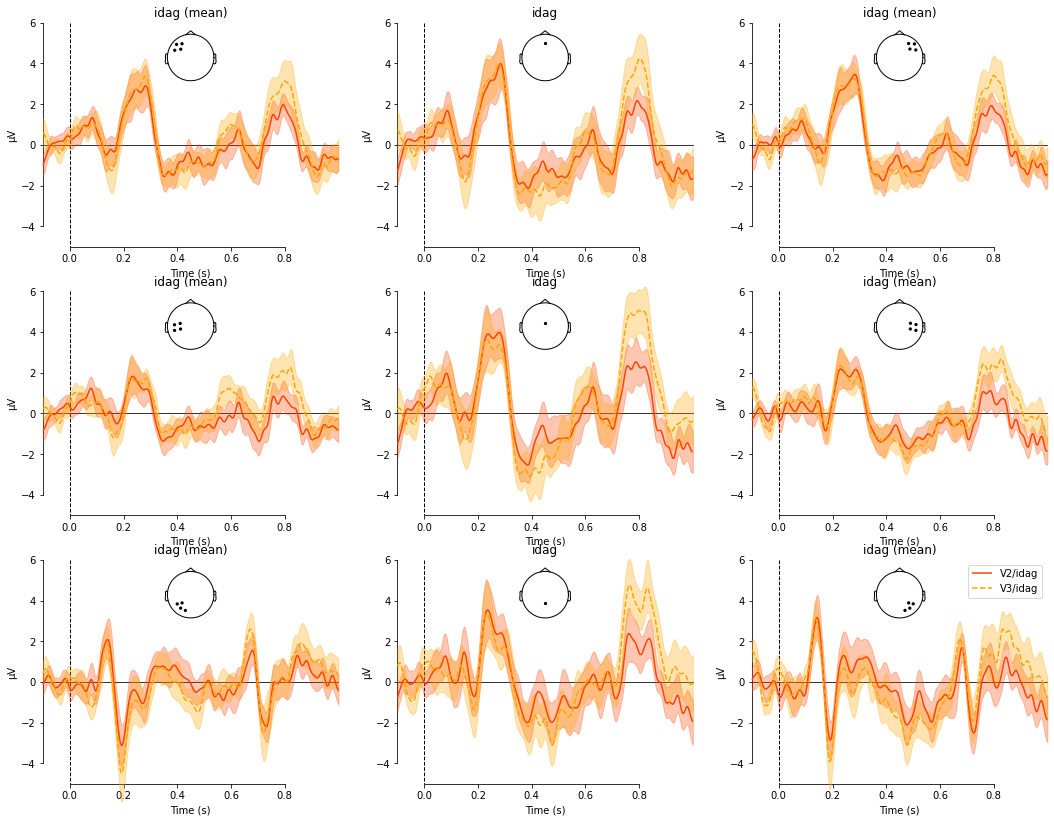

In [25]:
cond = 'idag'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='upper right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({c:evokeds_reg_merged[c] for c in conditions if cond in c},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 colors=[colors[c] for c in conditions if cond in c], 
                                 linestyles=[linestyles[c] for c in  conditions if cond in c],
                                 show_sensors=head_pos, legend=legend, 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_' + cond + '_CIs_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_' + cond + '_CIs.svg')
plt.close()
plt.show()

---
# Contrasts 

### Topo Plots

#### 100 ms time windows

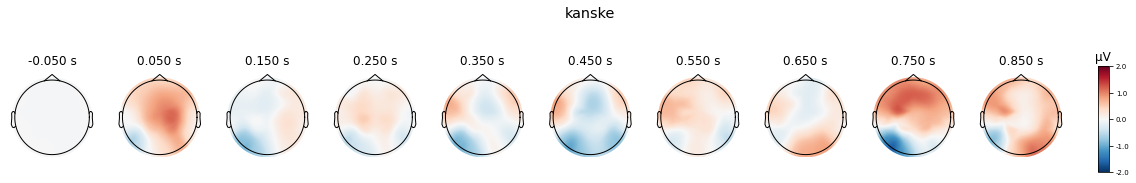

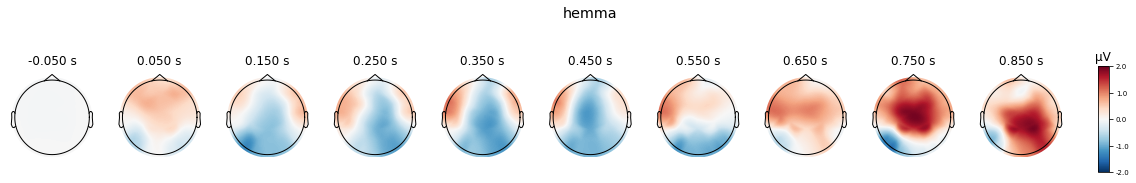

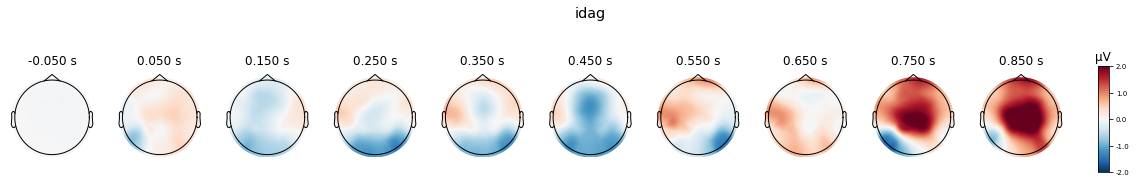

In [26]:
times = np.arange(-.050, .950, .100)

uv_range = 2

for contr in contrasts:
     mne.grand_average(evokeds_diff[contr]).plot_topomap(times, average=0.100,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      )

### A priori time windows

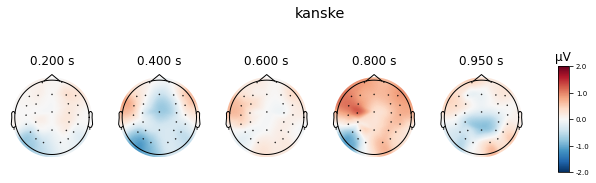

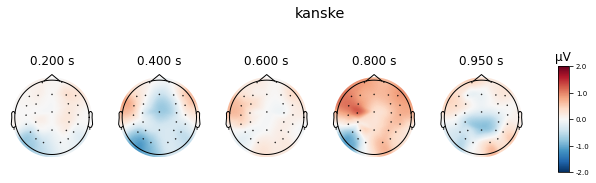

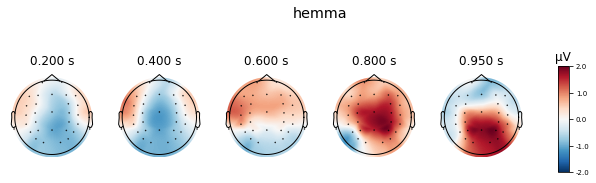

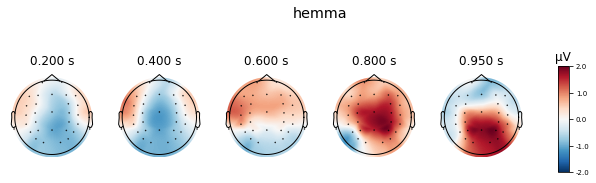

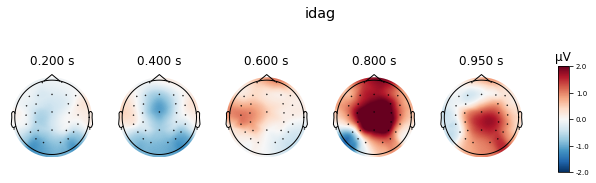

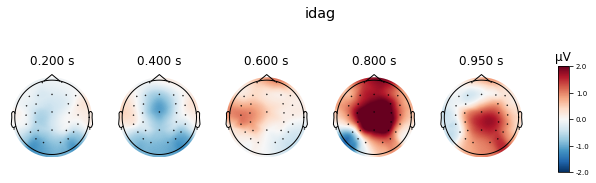

In [27]:
uv_range = 2

for contr in contrasts:
    mne.grand_average(evokeds_diff[contr]).plot_topomap([np.median(t) for t in time_wins], 
                                                         average=0.120,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=True, 
                                                         contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      ).savefig(figure_path + 'topos_V3-V2_' + contr + '_' + str(dpi) + 'dpi.png')        
    # export again, as vector graphic
    mne.grand_average(evokeds_diff[contr]).plot_topomap([np.median(t) for t in time_wins], 
                                                         average=0.120,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=True, 
                                                         contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      ).savefig(svg_path + 'topos_V3-V2_' + contr + '.svg')        

    plt.show()

### Contrast waveforms

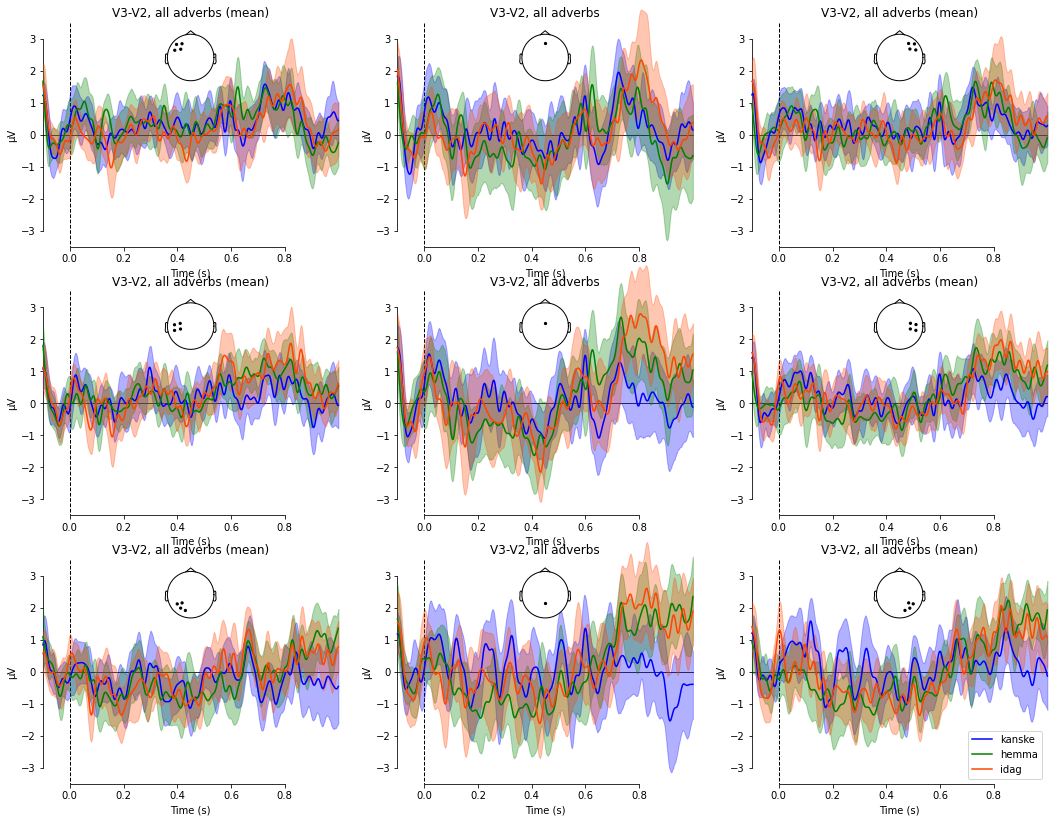

In [28]:
ylim = {'eeg':[-3.5, 3.5]}

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='lower right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({cond:evokeds_diff[cond] for cond in evokeds_diff},
                                 picks=chans, combine='mean',
                                 title='V3-V2, all adverbs',
                                 ylim=ylim,
                                 colors=contr_colors, #linestyles=linestyles,
                                 show_sensors=head_pos, legend=legend, 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1
    
fig.savefig(figure_path + 'waveforms_diff_all_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_diff_all.svg')
plt.close()
plt.show()

### kanske
#### V3-V2

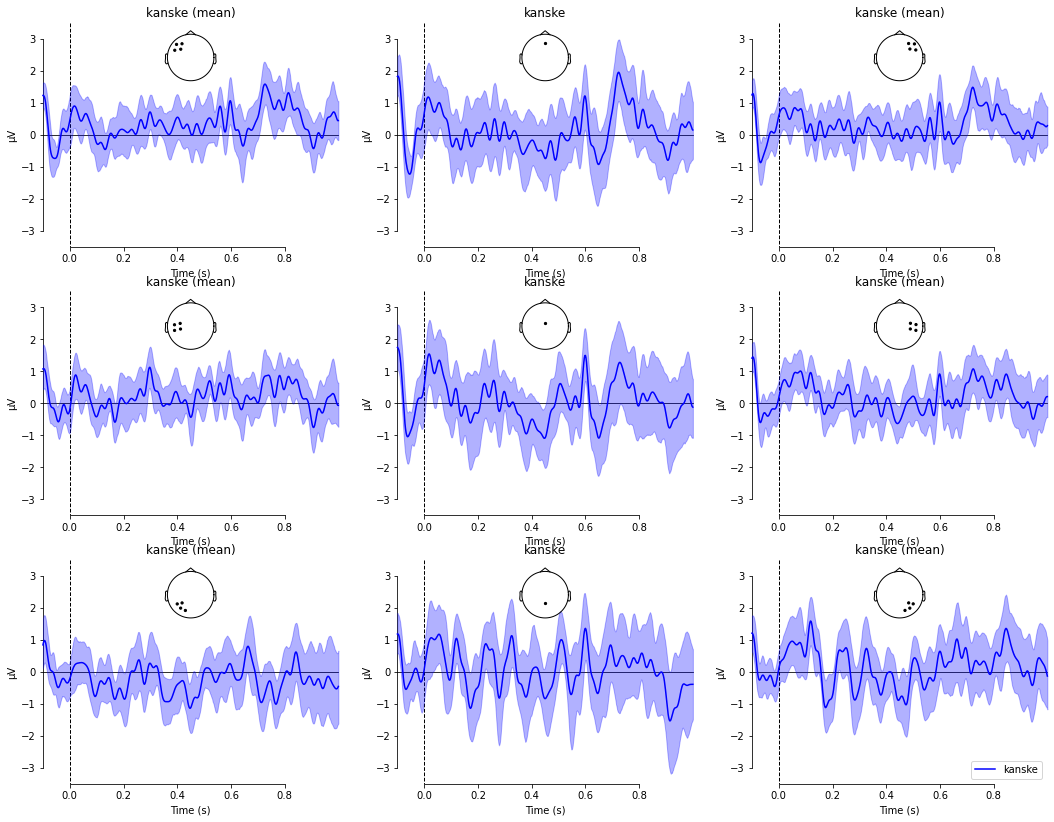

In [29]:
cond = 'kanske'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='lower right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({cond:evokeds_diff[cond]},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 show_sensors=head_pos, legend=legend, 
                                 colors=[contr_colors[c] for c in contrasts if cond in c], 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(svg_path + 'waveforms_V3-V2_' + cond + '.svg')
plt.close()
plt.show()

### hemma
#### V3-V2

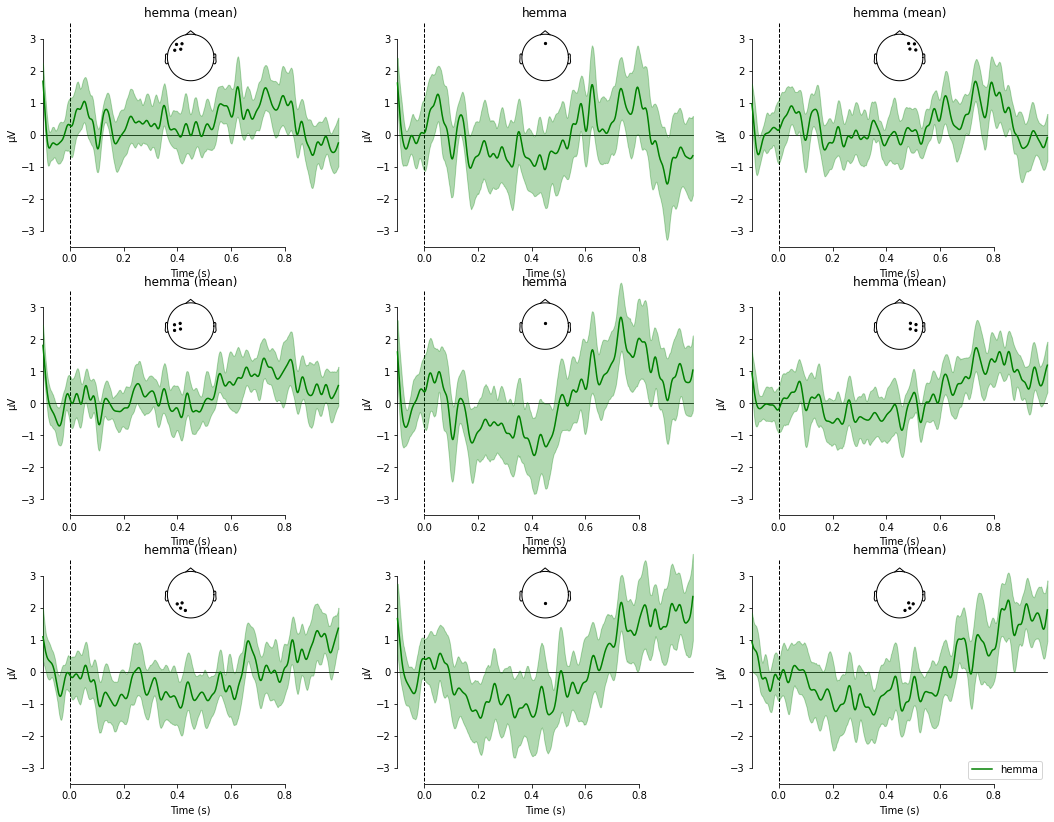

In [30]:
cond = 'hemma'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='lower right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({cond:evokeds_diff[cond]},
#         {c:evoked_bs100[c] for c in conditions[4:6]},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 show_sensors=head_pos, legend=legend, 
                                 colors=[contr_colors[c] for c in contrasts if cond in c], 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_V3-V2_' + cond + '_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_V3-V2_' + cond + '.svg')
plt.close()
plt.show()

### idag
#### V3-V2

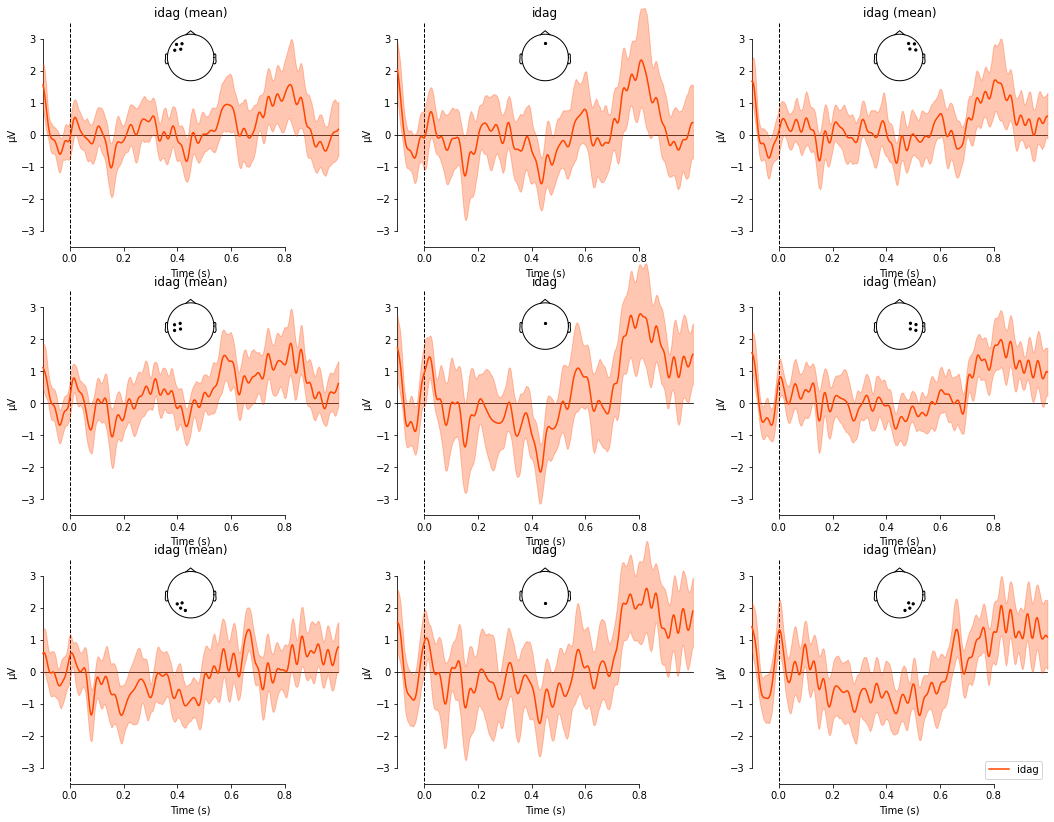

In [31]:
cond = 'idag'

fig, axs = plt.subplots(3, 3, figsize=figsize)    
ax = 0
for roi, chans in rois.items():
    if ax == (len(rois.items())-1):
        legend='lower right'
        show=True
    else:
        legend=False
        show=False

    mne.viz.plot_compare_evokeds({cond:evokeds_diff[cond]},
                                 picks=chans, combine='mean',
                                 title=cond,
                                 ylim=ylim,
                                 show_sensors=head_pos, legend=legend, 
                                 colors=[contr_colors[c] for c in contrasts if cond in c], 
                                 ci=True,
                                 axes=axs.reshape(-1)[ax], show=show
                                );
    ax += 1

fig.savefig(figure_path + 'waveforms_V3-V2_' + cond + '_' + str(dpi) + 'dpi.png')
fig.savefig(svg_path + 'waveforms_V3-V2_' + cond + '.svg')
plt.close()
plt.show()